<a href="https://colab.research.google.com/github/Riojiro/CompBio2018Code/blob/master/u_net_sim_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import os
import sys
from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
masks = sorted(glob.glob("/content/drive/My Drive/bone_sim_data/label_3class/01/*.tif"))
orgs = sorted(glob.glob("/content/drive/My Drive/bone_sim_data/noisy/01/*.tif"))

In [6]:
print(len(orgs),len(masks))

400 400


In [0]:
imgs_list = []
masks_list = []
for image, mask in zip(orgs, masks):
    imgs_list.append(np.array(Image.open(image).resize((512,512))))
    
    im = Image.open(mask).resize((512,512))
   
    masks_list.append(np.array(im))

imgs_np = np.asarray(imgs_list)
masks_np = np.asarray(masks_list)

In [59]:
print(imgs_np.shape, masks_np.shape)

(400, 512, 512) (400, 512, 512)


In [10]:
pip install keras-unet

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

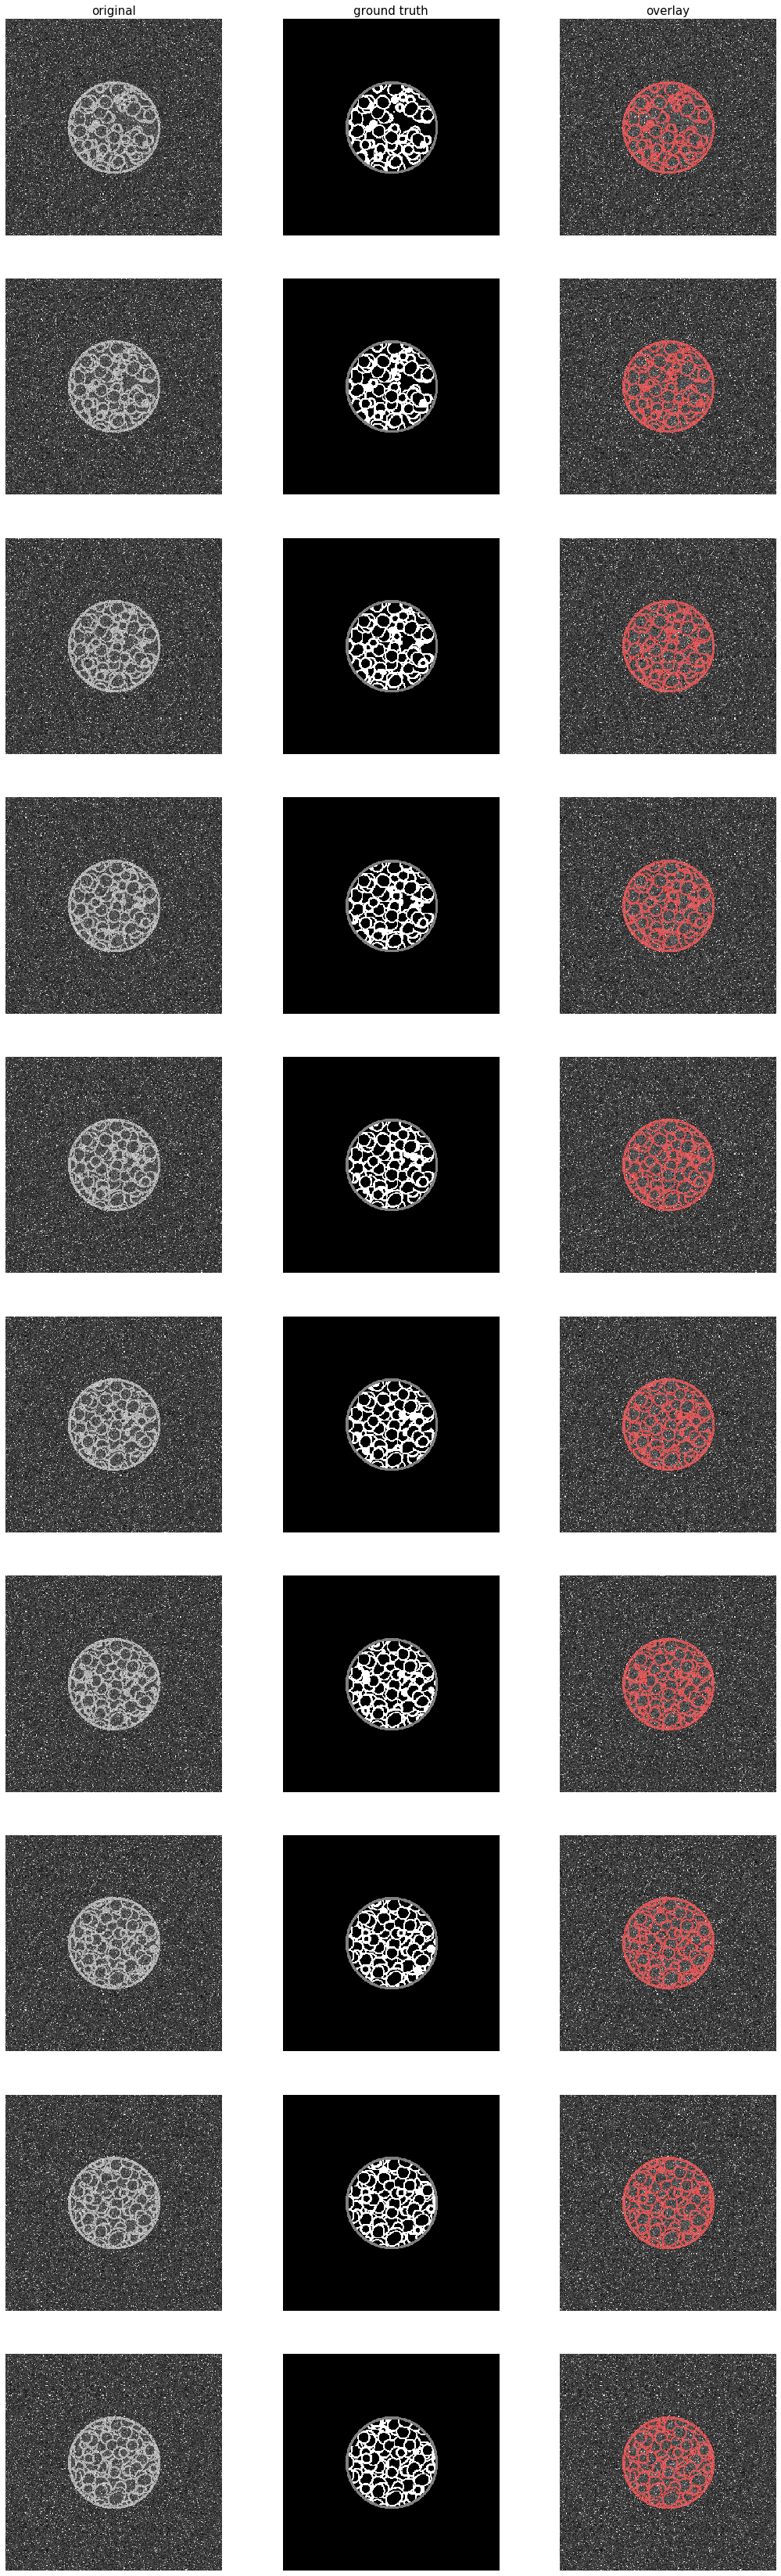

In [61]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=imgs_np, mask_imgs=masks_np, nm_img_to_plot=10, figsize=6)

In [62]:
print(imgs_np.max(), masks_np.max())

255 2


In [0]:
x = np.asarray(imgs_np, dtype=np.float32)/255
#y = np.asarray(masks_np, dtype=np.float32)/2
y=np.copy(masks_np)

In [0]:
from sklearn.preprocessing import OneHotEncoder

In [0]:
ohe=OneHotEncoder(sparse=False,categories=[[1,2]],handle_unknown="ignore",)

In [0]:
y = ohe.fit_transform(y.reshape(y.shape[0]*y.shape[1]*y.shape[2],-1).astype("int8")).reshape(y.shape[0],y.shape[1],y.shape[2],2)

In [64]:
print(x.max(), y.max())

1.0 1.0


In [15]:
print(x.shape, y.shape)

(400, 512, 512) (400, 512, 512, 2)


In [0]:
y = y.reshape(y.shape[0], y.shape[1], y.shape[2], 1)
print(x.shape, y.shape)

In [16]:
x = x.reshape(x.shape[0], x.shape[1], x.shape[2], 1)
print(x.shape, y.shape)

(400, 512, 512, 1) (400, 512, 512, 2)


In [17]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.5, random_state=0)

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (200, 512, 512, 1)
y_train:  (200, 512, 512, 2)
x_val:  (200, 512, 512, 1)
y_val:  (200, 512, 512, 2)


In [18]:
from keras_unet.utils import get_augmented

train_gen = get_augmented(
    x_train, y_train, batch_size=2,
    data_gen_args = dict(
        rotation_range=15.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=50,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    ))

Using TensorFlow backend.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:940: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (200, 512, 512, 2) (2 channels).
  ' channels).')
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (200, 512, 512, 2) (2 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


(2, 512, 512, 1) (2, 512, 512, 2)


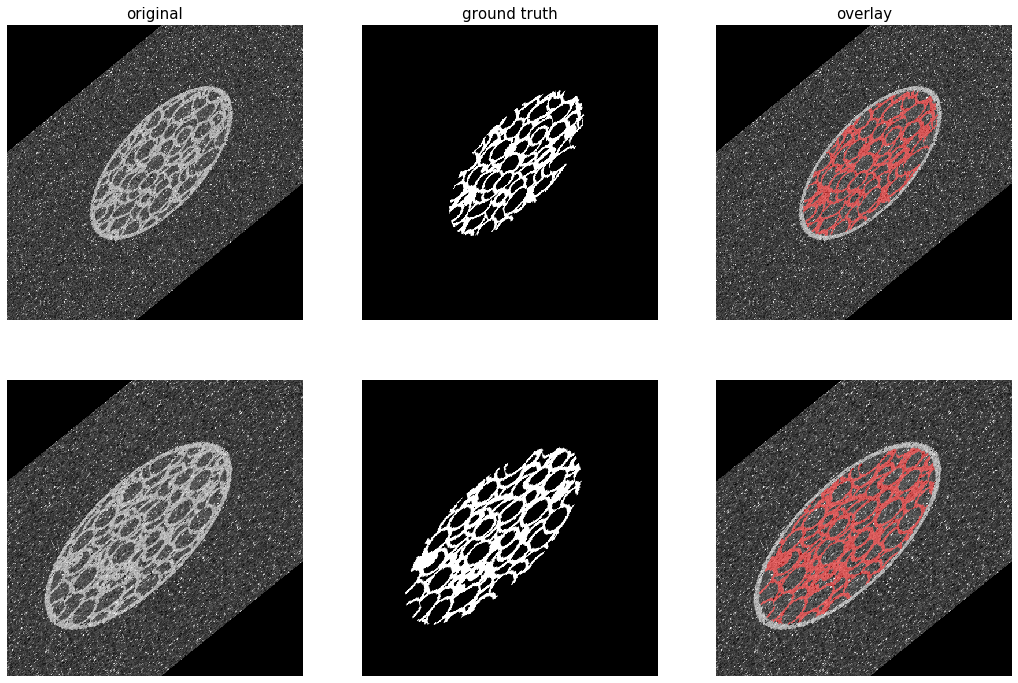

In [37]:
sample_batch = next(train_gen)
xx, yy = sample_batch
print(xx.shape, yy.shape)
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=xx, mask_imgs=yy[:,:,:,1], nm_img_to_plot=4, figsize=6)

In [0]:
from keras_unet.models import custom_unet

input_shape = x_train[0].shape

model = custom_unet(
    input_shape,
    use_batch_norm=False,
    num_classes=2,
    filters=64,
    dropout=0.2,
    output_activation='sigmoid'
)

In [39]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 512, 512, 64) 640         input_2[0][0]                    
__________________________________________________________________________________________________
dropout_6 (Dropout)             (None, 512, 512, 64) 0           conv2d_20[0][0]                  
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 512, 512, 64) 36928       dropout_6[0][0]                  
____________________________________________________________________________________________

In [0]:
import os
os.environ["PATH"] += os.pathsep + "C:\\Program Files (x86)\\Graphviz2.38\\bin\\"

In [22]:
import sys
print(sys.path)

sys.path.append("C:\\Program Files (x86)\\Graphviz2.38\\bin\\") 

print(sys.path)

['', '/env/python', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/root/.ipython']
['', '/env/python', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/root/.ipython', 'C:\\Program Files (x86)\\Graphviz2.38\\bin\\']


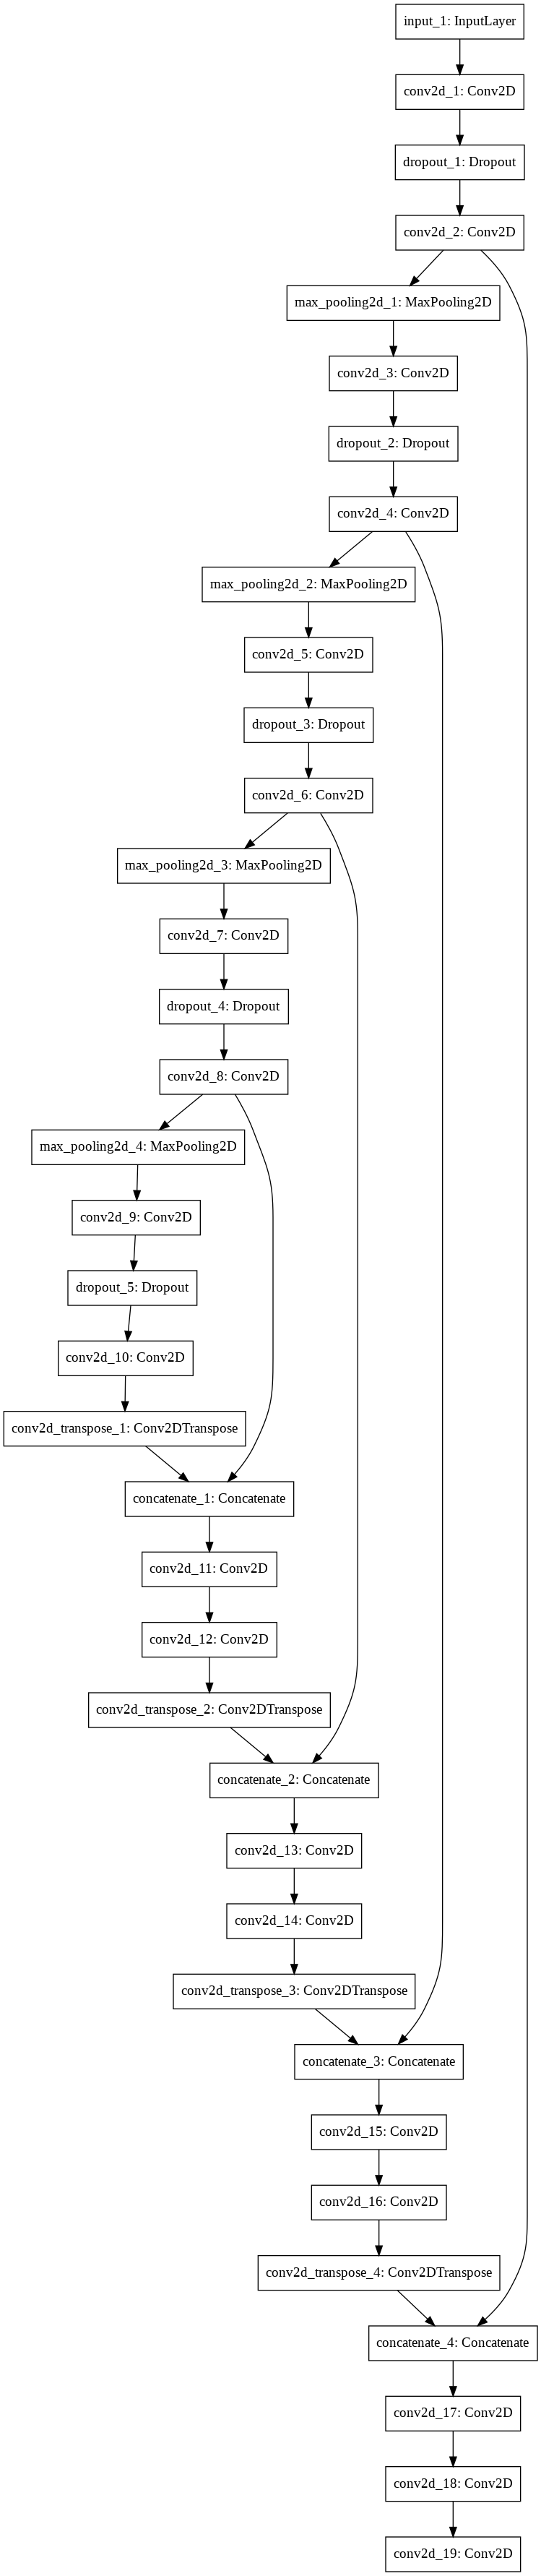

In [23]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [0]:
from keras.callbacks import ModelCheckpoint


model_filename = 'segm_model_c3_v0.h5'
callback_checkpoint = ModelCheckpoint(
    model_filename, 
    verbose=1, 
    monitor='val_loss', 
    save_best_only=True,
)

In [0]:
from keras.optimizers import Adam, SGD
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance

model.compile(
    #optimizer=Adam(), 
    optimizer=SGD(lr=0.01, momentum=0.99),
    loss='binary_crossentropy',
    #loss=jaccard_distance,
    metrics=[iou, iou_thresholded]
)

In [42]:
history = model.fit_generator(
    train_gen,
    steps_per_epoch=100,
    epochs=10,
    
    validation_data=(x_val, y_val),
    callbacks=[callback_checkpoint]
)

Epoch 1/10
100/100 [==============================] - 35s 345ms/step - loss: 0.1929 - iou: 0.0934 - iou_thresholded: 0.1113 - val_loss: 0.0410 - val_iou: 0.4544 - val_iou_thresholded: 0.5590

Epoch 00001: val_loss improved from inf to 0.04104, saving model to segm_model_c3_v0.h5
Epoch 2/10
100/100 [==============================] - 33s 328ms/step - loss: 0.0538 - iou: 0.3863 - iou_thresholded: 0.5198 - val_loss: 0.0391 - val_iou: 0.3819 - val_iou_thresholded: 0.5498

Epoch 00002: val_loss improved from 0.04104 to 0.03914, saving model to segm_model_c3_v0.h5
Epoch 3/10
100/100 [==============================] - 33s 328ms/step - loss: 0.0484 - iou: 0.3600 - iou_thresholded: 0.5003 - val_loss: 0.0394 - val_iou: 0.3672 - val_iou_thresholded: 0.5460

Epoch 00003: val_loss did not improve from 0.03914
Epoch 4/10
100/100 [==============================] - 33s 328ms/step - loss: 0.0451 - iou: 0.3787 - iou_thresholded: 0.5302 - val_loss: 0.0386 - val_iou: 0.4290 - val_iou_thresholded: 0.5584

E

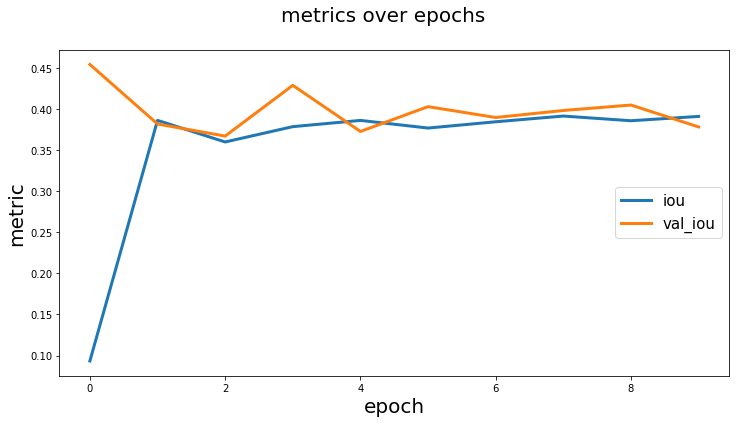

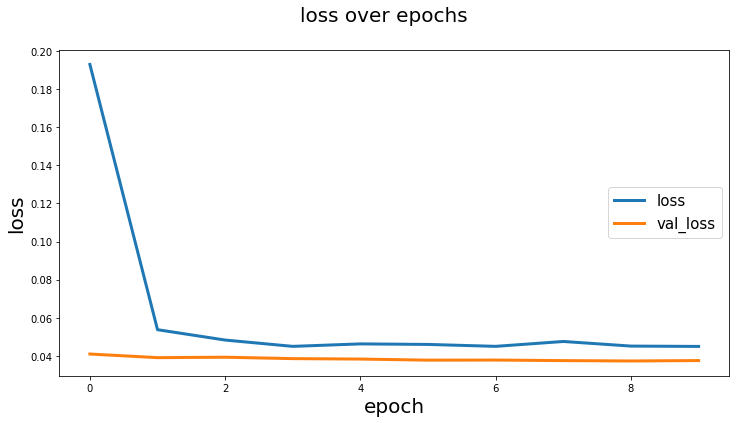

In [43]:
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

In [0]:
model.load_weights(model_filename)
y_pred = model.predict(x_val)

In [30]:
y_pred[0]

array([[[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       ...,

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]]], dtype=float32)

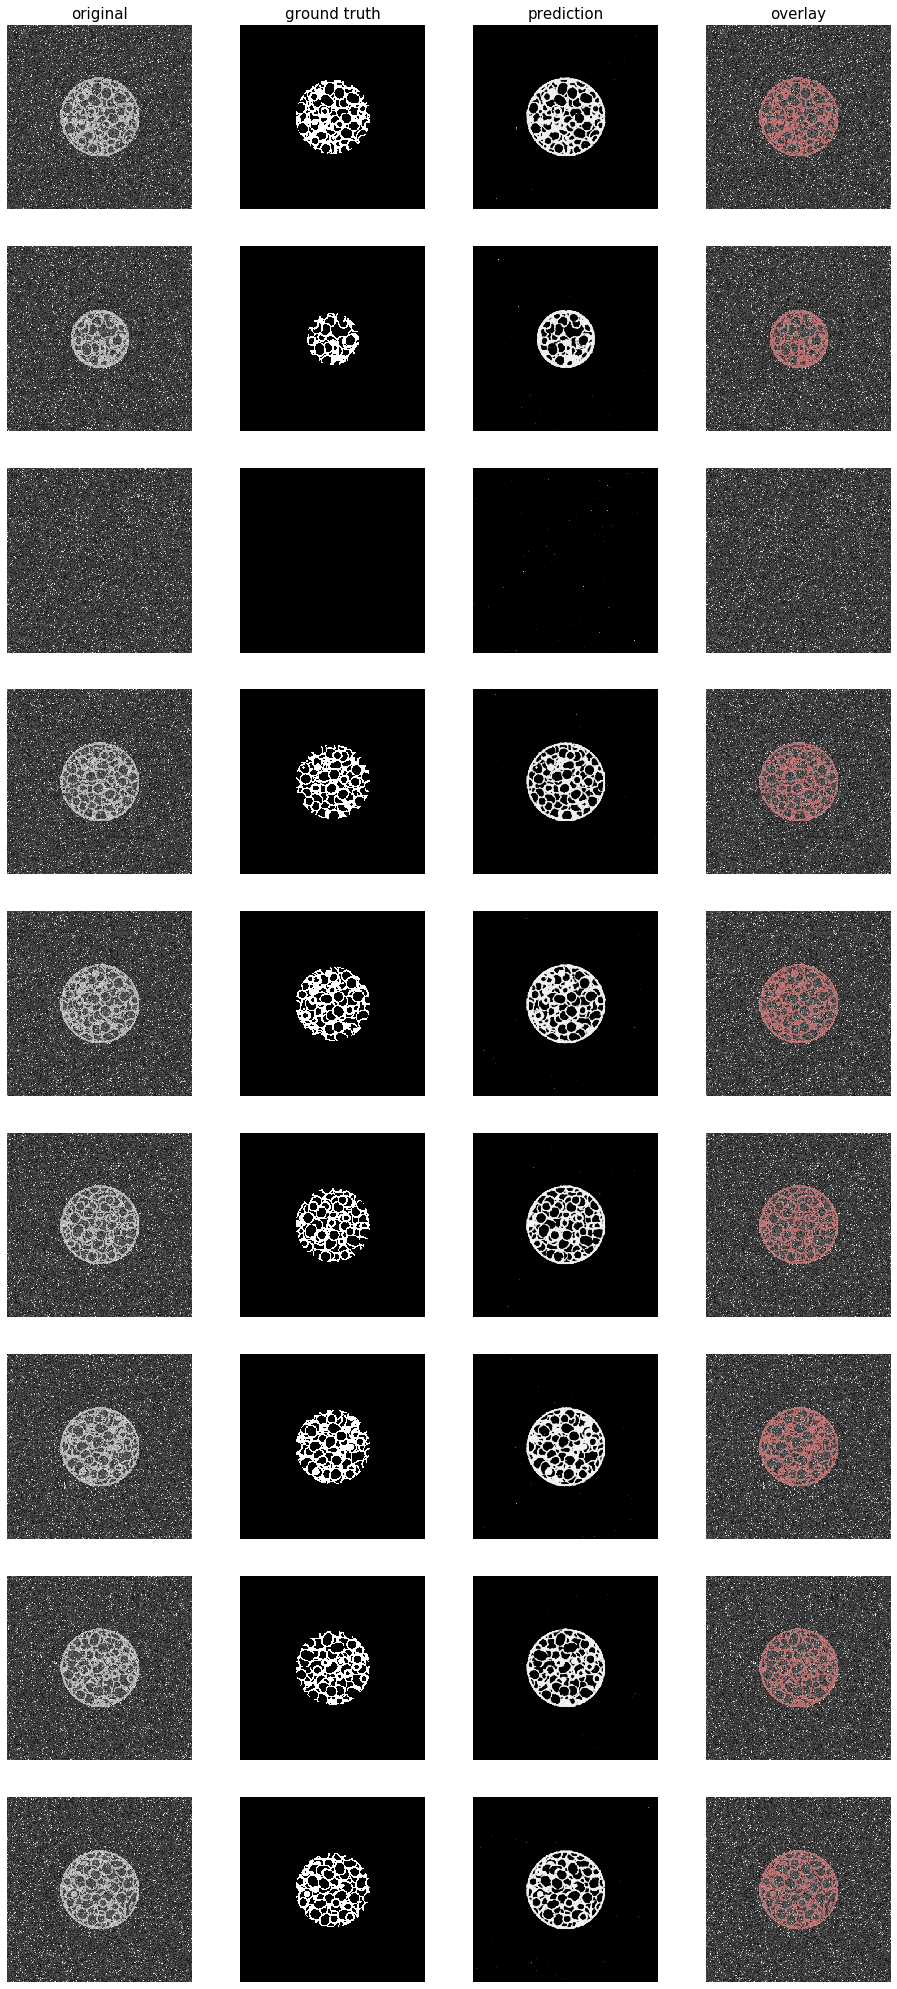

In [47]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=x_val, mask_imgs=y_val[:,:,:,1], pred_imgs=y_pred[:,:,:,1], nm_img_to_plot=9)

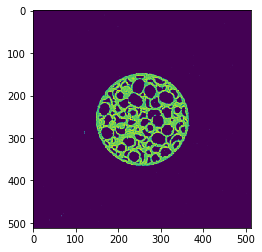

In [32]:
plt.imshow(y_pred[0,:,:,1])

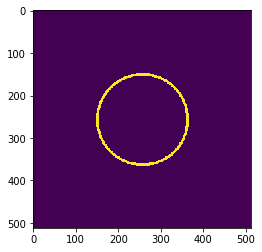

In [34]:
plt.imshow(y[0,:,:,0])